In [29]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import joypy

### Load the image and labels.

In [2]:
train_img = np.array(Image.open('sample_training_region1/sample_training_region1.tif'))
train_label = np.array(Image.open('sample_training_region1/sample_training_region1_trees.tif'))
train_img.shape

(259, 262, 4)

### Put information of each pixel as a row into a dataframe.

In [3]:
def find_area(img, x, y, d=1):
    return img[max(0, x-d):x+d+1, max(0, y-d):y+d+1].astype(int)

def get_ndvi_around(area):
    ndvi = []
    n = len(area) * len(area[0])
    for row in area:
        for pix in row:
            ndvi.append((pix[3] - pix[0]) / (pix[3] + pix[0]) if pix[3] + pix[0] else 0)
    return ndvi

In [15]:
x = pd.DataFrame({'x': range(0, len(train_img))})
y = pd.DataFrame({'y': range(0, len(train_img[0]))})

df = x.assign(foo = 1).merge(y.assign(foo = 1), on = 'foo').drop(columns = ['foo'])

In [16]:
# Extract the basic information of each pixel, which contains r, g, b, NIR and NDVI.
df[['r', 'g', 'b', 'NIR']] = pd.DataFrame(df.apply(
    lambda x:train_img[int(x['x']), int(x['y'])].astype(int), axis = 1).tolist())

df['NDVI'] = df.apply(
    lambda x: (x['NIR']-x['r']) / (x['NIR']+x['r']) if x['NIR']+x['r'] else 0, axis = 1)

# Extract the information of surrounding pixels ofeach pixel, including min, max, average, std of basic information.
df[['r_avg', 'g_avg', 'b_avg', 'NIR_avg']] = pd.DataFrame(
    df.apply(lambda x:np.average(find_area(train_img, int(x['x']), int(x['y']), 2), axis = (0,1)), axis = 1).tolist())

df[['r_std', 'g_std', 'b_std', 'NIR_std']] = pd.DataFrame(
    df.apply(lambda x:np.std(find_area(train_img, int(x['x']), int(x['y']), 2), axis = (0,1)), axis = 1).tolist())

df['NDVI_min'] = df.apply(
    lambda x: np.min(get_ndvi_around(find_area(train_img, int(x['x']), int(x['y']), 2))), axis = 1)

df['NDVI_max'] = df.apply(
    lambda x: np.max(get_ndvi_around(find_area(train_img, int(x['x']), int(x['y']), 2))), axis = 1)

df['NDVI_avg'] = df.apply(
    lambda x: np.average(get_ndvi_around(find_area(train_img, int(x['x']), int(x['y']), 2))), axis = 1)

df['NDVI_std'] = df.apply(
    lambda x: np.std(get_ndvi_around(find_area(train_img, int(x['x']), int(x['y']), 2))), axis = 1)

In [17]:
df[10000:10100]

,x,y,r,g,b,NIR,NDVI,r_avg,g_avg,b_avg,NIR_avg,r_std,g_std,b_std,NIR_std,NDVI_min,NDVI_max,NDVI_avg,NDVI_std
10000,38,44,151,145,130,143,-0.027211,147.12,141.72,127.40,136.04,13.103648,13.727403,10.994544,12.255546,-0.054795,-0.027211,-0.039167,0.006888
10001,38,45,151,145,130,143,-0.027211,151.92,146.60,131.44,140.64,10.732828,11.384200,9.073390,9.698990,-0.054795,-0.020690,-0.038496,0.007384
10002,38,46,154,149,134,143,-0.037037,154.96,149.92,133.68,143.64,6.855538,7.730045,6.329107,5.816391,-0.050167,-0.020690,-0.037833,0.006744
10003,38,47,160,155,139,149,-0.035599,157.16,152.32,135.44,145.44,6.116731,6.727377,5.470503,5.004638,-0.050167,-0.020690,-0.038647,0.006512
10004,38,48,158,154,136,145,-0.042904,159.56,154.88,137.48,147.20,4.988627,5.038412,4.299953,3.429286,-0.052632,-0.020690,-0.040182,0.006890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10095,38,139,133,129,117,135,0.007463,130.04,129.40,117.80,144.92,26.535229,22.222511,21.449476,16.314215,-0.095785,0.370690,0.060710,0.146422
10096,38,140,143,141,127,124,-0.071161,143.64,140.84,129.04,138.68,14.872471,14.315530,15.050528,15.762538,-0.101562,0.107914,-0.018257,0.075963
10097,38,141,145,142,134,122,-0.086142,148.80,145.80,134.80,135.44,15.057224,14.923806,15.737852,15.947614,-0.103175,0.107914,-0.047862,0.062467
10098,38,142,148,147,139,126,-0.080292,155.64,152.36,141.92,133.72,13.999657,14.164406,14.433073,15.567967,-0.103175,-0.046243,-0.077048,0.016252


Clean up the tree labels.

In [18]:
train_label.shape

(259, 262)

In [19]:
# Add tree label to each pixel and label the row with positive label and NDVI value greater than 0.3 as 2.
def add_label(x, y):
    label = train_label[x, y]
    if label == 1 and df[(df.x == x) & (df.y == y)]['NDVI'].iloc[0] < 0.3:
        return 2
    return label

df['label'] = df.apply(lambda x: add_label(int(x['x']), int(x['y'])), axis=1)

In [9]:
# Drop the rows with label 2.
# df = df[df['label'] != 2]

In [20]:
df

,x,y,r,g,b,NIR,NDVI,r_avg,g_avg,b_avg,NIR_avg,r_std,g_std,b_std,NIR_std,NDVI_min,NDVI_max,NDVI_avg,NDVI_std,label
0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,3,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,4,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67853,258,257,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
67854,258,258,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
67855,258,259,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
67856,258,260,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


EDAV

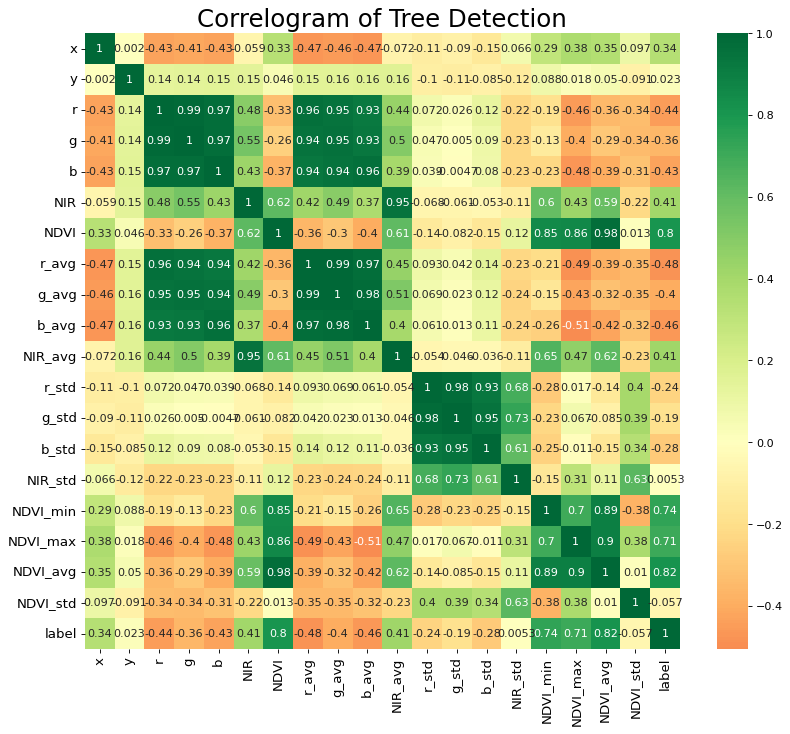

In [22]:
df_t = df[df['label'] != 2]
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df_t.corr(), xticklabels=df_t.corr().columns, yticklabels=df_t.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Correlogram of Tree Detection', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The most important fact we could notice from the correlogram above is the label has highest correlation with NDVI and NDVI_avg.

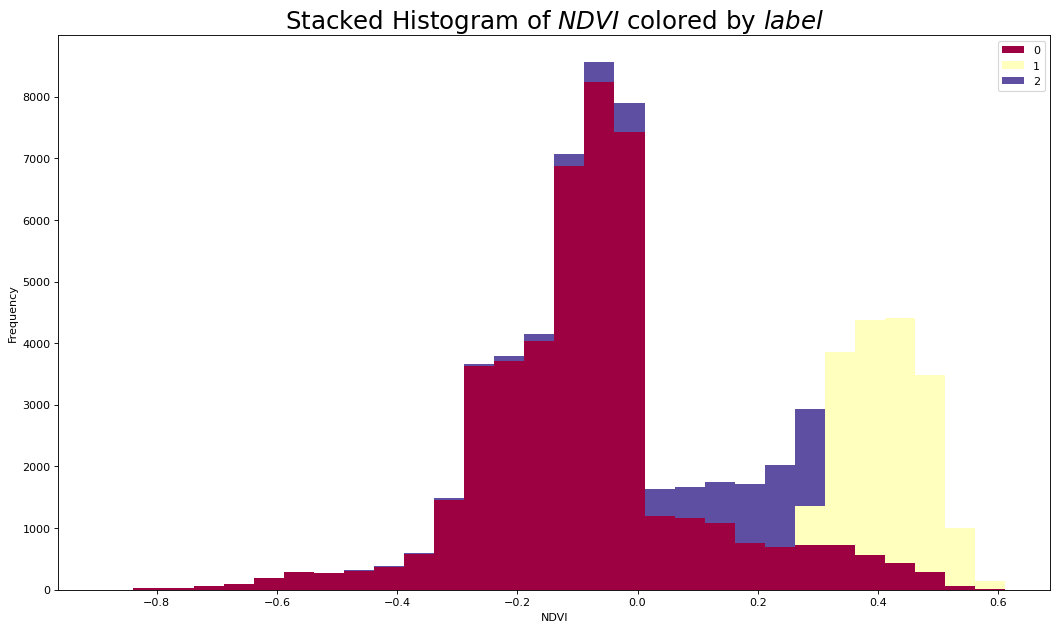

In [23]:
# Prepare data
x_var = 'NDVI'
groupby_var = 'label'
df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df[x_var].values.tolist() for i, df in df_agg]

plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, 30, stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.show()

/var/folders/ct/39dm855d57zd5qz0f0pjk8d40000gn/T/ipykernel_10495/3430631059.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['label'] == 0, "NDVI"], shade=True, color="grey", label="NoTree", alpha=.7)
/var/folders/ct/39dm855d57zd5qz0f0pjk8d40000gn/T/ipykernel_10495/3430631059.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['label'] == 1, "NDVI"], shade=True, color="green", label="Tree", alpha=.7)
/var/folders/ct/39dm855d57zd5qz0f0pjk8d40000gn/T/ipykernel_10495/3430631059.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['label'] == 2, "NDVI"], shade=True, color="dodgerblue", label="

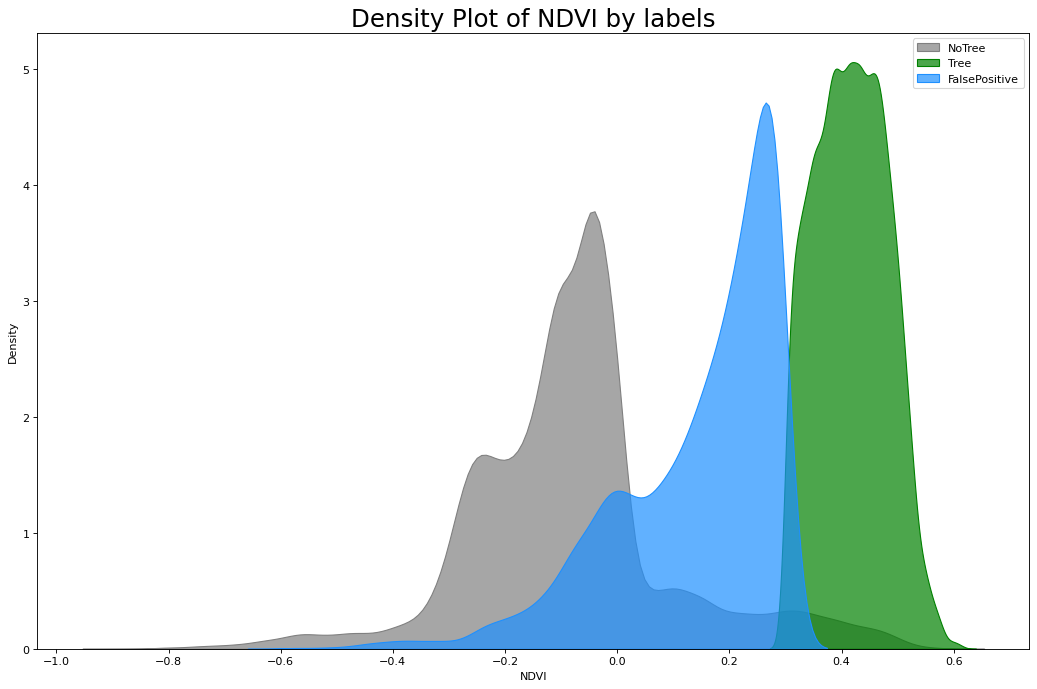

In [26]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(df.loc[df['label'] == 0, "NDVI"], shade=True, color="grey", label="NoTree", alpha=.7)
sns.kdeplot(df.loc[df['label'] == 1, "NDVI"], shade=True, color="green", label="Tree", alpha=.7)
sns.kdeplot(df.loc[df['label'] == 2, "NDVI"], shade=True, color="dodgerblue", label="FalsePositive", alpha=.7)

# Decoration
plt.title('Density Plot of NDVI by labels', fontsize=22)
plt.legend()
plt.show()

/var/folders/ct/39dm855d57zd5qz0f0pjk8d40000gn/T/ipykernel_10495/198266346.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['label'] == 0, "NDVI"], shade=True, color="grey", label="NoTree", alpha=.7)
/var/folders/ct/39dm855d57zd5qz0f0pjk8d40000gn/T/ipykernel_10495/198266346.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['label'] > 0, "NDVI"], shade=True, color="green", label="Tree", alpha=.7)


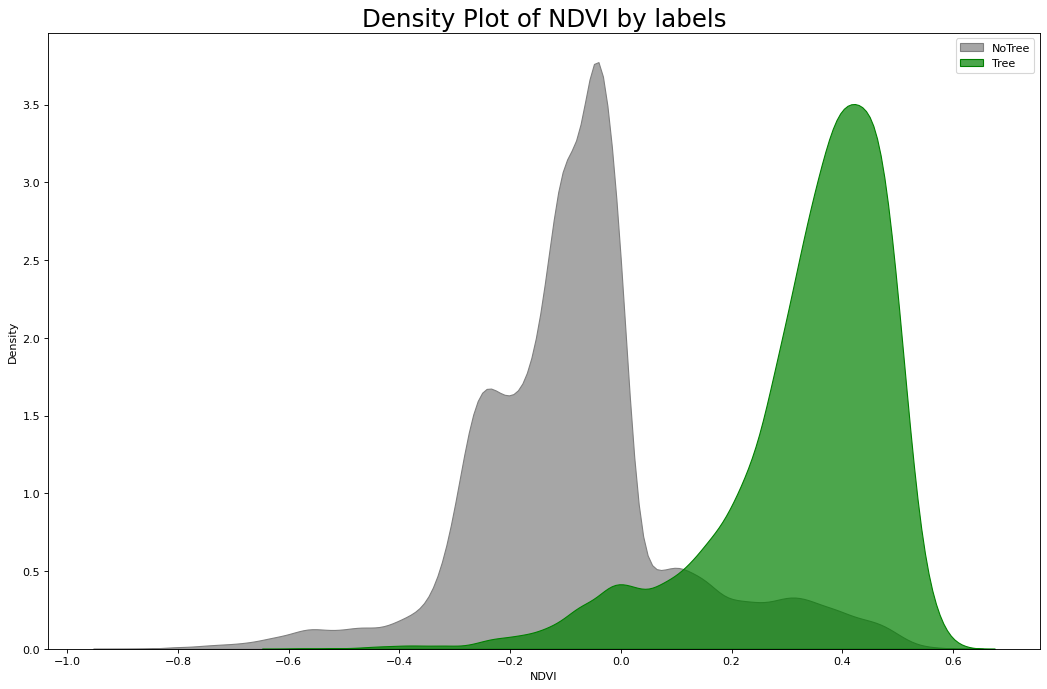

In [27]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(df.loc[df['label'] == 0, "NDVI"], shade=True, color="grey", label="NoTree", alpha=.7)
sns.kdeplot(df.loc[df['label'] > 0, "NDVI"], shade=True, color="green", label="Tree", alpha=.7)

# Decoration
plt.title('Density Plot of NDVI by labels', fontsize=22)
plt.legend()
plt.show()

<Figure size 1600x1000 with 0 Axes>

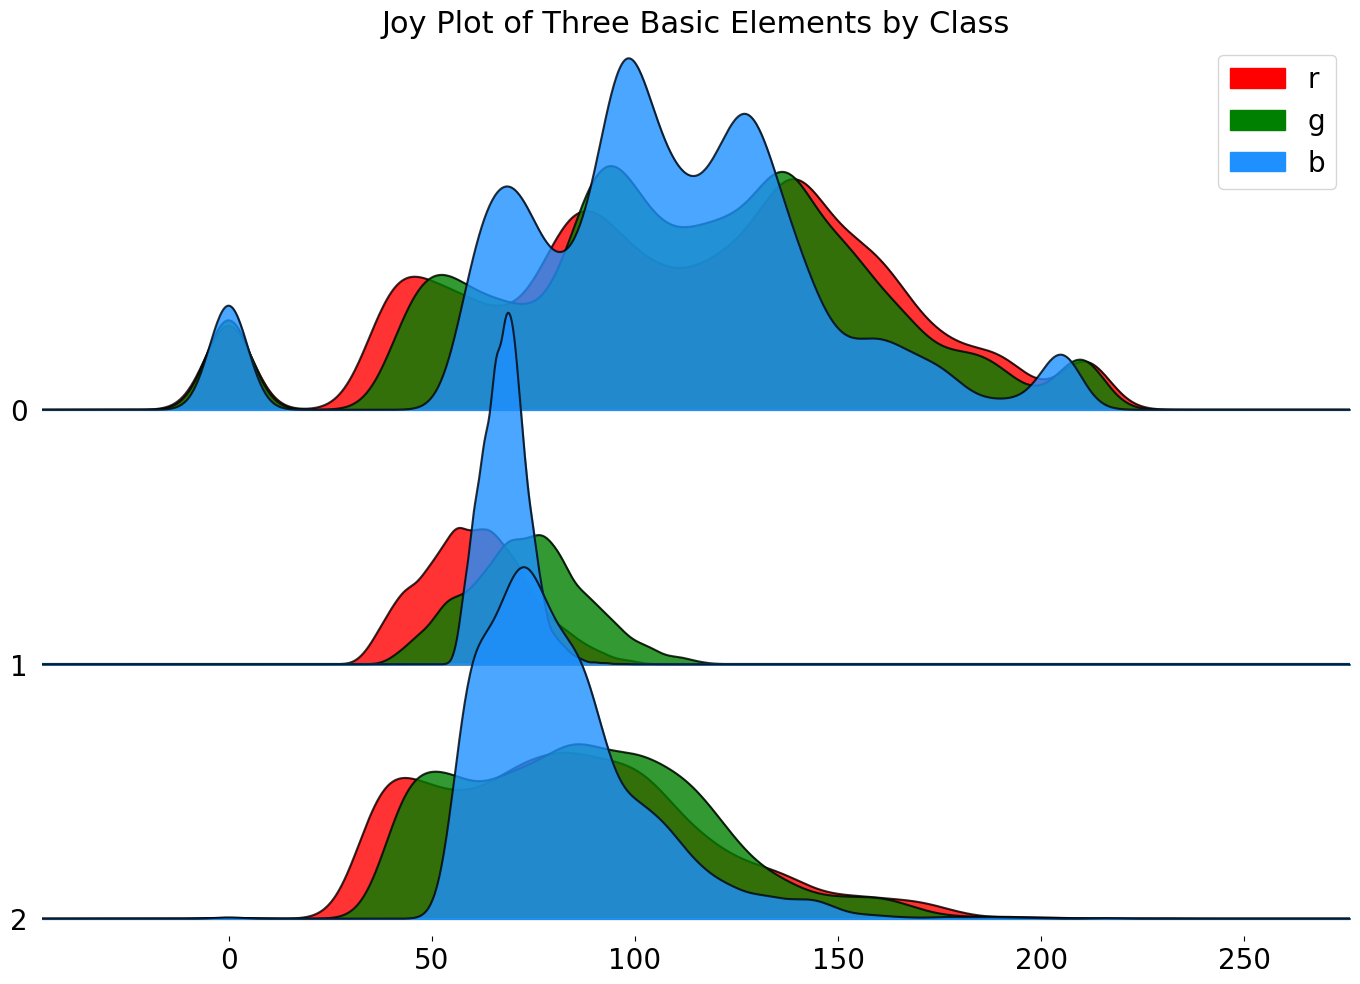

In [39]:
# Draw Plot
plt.figure(figsize=(16,10))
fig, axes = joypy.joyplot(df, column=['r', 'g', 'b'], color=['red', 'green', 'dodgerblue'], by="label", ylim='own', figsize=(14,10), legend=True, alpha=0.8)

# Decoration
plt.title('Joy Plot of Three Basic Elements by Class', fontsize=22)
plt.rc("font", size=20)
plt.show()

### Load and filter good region

In [21]:
background_img = Image.open('./good_region/region_background.tif')
trees_img = Image.open('./good_region/region_trees.tif')
background_array = np.array(background_img, dtype='int64')
trees_array = np.array(trees_img, dtype='int64')

In [22]:
print(trees_array.shape, trees_array.sum())
print(background_array.shape)

(127, 99) 1199
(127, 99, 4)


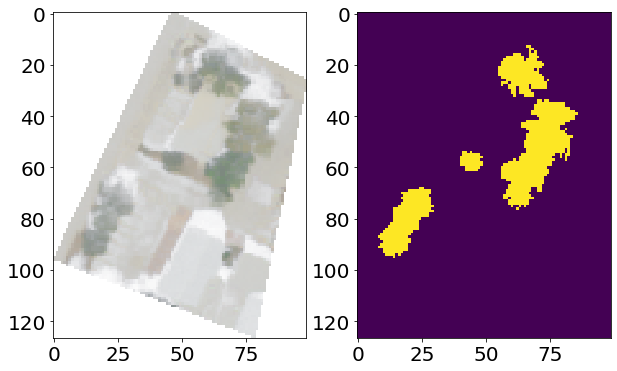

In [23]:
f, ax = plt.subplots(1,2,figsize=(10, 10))
ax[0].imshow(background_img)
ax[1].imshow(trees_array)

In [24]:
n, m = trees_array.shape
threshold = 0.3

def calcutae_NDVI(channels):
    red = channels[0]
    NIR = channels[3]
    
    if NIR+red == 0:
        return 0
    else:
        return (NIR-red)/(NIR+red)

for i in range(n):
    for j in range(m):
        if trees_array[i,j] != 0 and sum(background_array[i,j]) != 0: # label is 1 and not white
            if (calcutae_NDVI(background_array[i,j]) < threshold):
                trees_array[i,j] = 0

(127, 99) 412


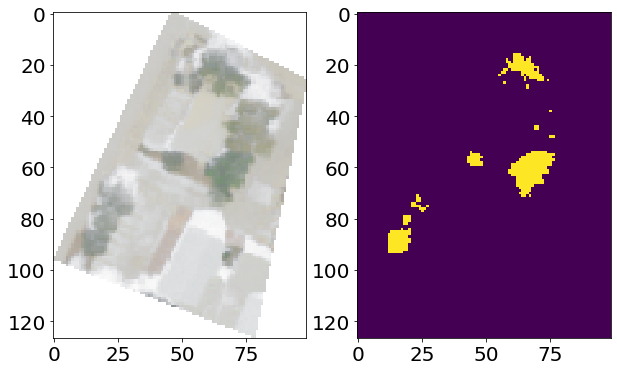

In [25]:
print(trees_array.shape, trees_array.sum())
f, ax = plt.subplots(1,2,figsize=(10, 10))
ax[0].imshow(background_img)
ax[1].imshow(trees_array)